# **POS Tagging**

# PART 4

## Installs, Imports and Paths

In [ ]:
!pip install scikit_learn
!pip install nltk
!pip install --upgrade wandb
!pip install tensorflow
!pip install scipy
!pip install scikeras
!pip install seqeval
!pip install --upgrade torch
!pip install gensim
!pip install ray[tune]
!pip install bert-for-tf2
!pip install --upgrade torch
!pip install --upgrade transformers
!pip install evaluate
!pip install datasets
!pip install wandb

In [2]:
from google.colab import files
import numpy as np
import pandas as pd
import nltk
import wandb
import tensorflow as tf
import os
import torch
import spacy
import keras
import evaluate
import seqeval
import warnings
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from nltk import sent_tokenize, word_tokenize, pos_tag
from sklearn.model_selection import learning_curve, GridSearchCV
from tabulate import tabulate
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from transformers import TFAutoModelForTokenClassification
from transformers.keras_callbacks import KerasMetricCallback
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray import tune

stemmer = WordNetLemmatizer()

In [3]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [4]:
!wandb login

wandb: Currently logged in as: karageorgisplatonas (nlp-squad). Use `wandb login --relogin` to force relogin


In [5]:
%env WANDB_LOG_MODEL=true

env: WANDB_LOG_MODEL=true


In [6]:
%env WANDB_PROJECT = sentiment-analysis

env: WANDB_PROJECT=sentiment-analysis


In [7]:
%env WANDB_NOTEBOOK_NAME = "/content/POS-Tagging-Part-4"

env: WANDB_NOTEBOOK_NAME="/content/POS-Tagging-Part-4"


In [8]:
if not os.path.exists('./POS-Tagging'):
  os.makedirs('./POS-Tagging')
os.chdir('./POS-Tagging')
uploaded = files.upload()

Saving en_lines-ud-dev.txt to en_lines-ud-dev (1).txt
Saving en_lines-ud-test.txt to en_lines-ud-test (1).txt
Saving en_lines-ud-train.txt to en_lines-ud-train (1).txt


## Data Preprocessing

In [9]:
def myData(name, percentage):
  with open(name, "r", encoding = 'utf8') as myfile:
    my_data = myfile.read()
    cropped_data = my_data[:int(len(my_data)*percentage)]

  return cropped_data


train_data = myData("en_lines-ud-train.txt", 1) # as a second parameter pass the percentage of the data you want
dev_data = myData("en_lines-ud-dev.txt", 1)
test_data = myData("en_lines-ud-test.txt", 1)

In [10]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('sentencizer')

# tokenize and lemmatize the data and finally create x-y list
def processing(my_data):
  
  tuples=[]
  x = []
  y = []
  for sent in my_data.sents:
    partial_tuple=[]
    temp_x = []
    temp_y = []
    for token in sent:
      if token.pos_:
        temp_x.append(token.lemma_)
        temp_y.append(token.pos_)
        partial_tuple.append((token.lemma_, token.pos_))
    tuples.append(partial_tuple)
    x.append(temp_x)
    y.append(temp_y)
  return tuples, x, y

train_tuples, x_train, y_train = processing(nlp(train_data))
dev_tuples, x_dev, y_dev = processing(nlp(dev_data))
test_tuples, x_test, y_test = processing(nlp(test_data))

## Prepare the ground for BERT

### Preview Data

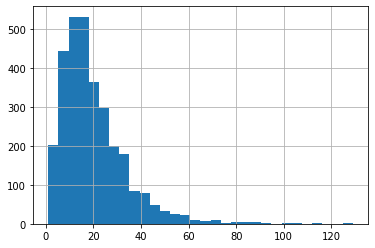

In [11]:
seq_len = [len(sentence) for sentence in x_train]
#new = [val for sublist in new for val in sublist]
pd.Series(seq_len).hist(bins=30)
# max sequence length for each document/sentence sample
max_length = 40

### Prepare the Data

In [12]:
classes = ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SPACE', 'SYM', 'VERB', 'X']
def enumerate_classes(classes):
    class2id = {cls: idx for idx, cls in enumerate(classes)}
    return class2id

In [13]:
class2id = enumerate_classes(classes)
y_train_encoded = [[class2id[tag] for tag in sentence] for sentence in y_train]
y_dev_encoded = [[class2id[tag] for tag in sentence] for sentence in y_dev]
y_test_encoded = [[class2id[tag] for tag in sentence] for sentence in y_test]

In [14]:
def create_format(tokens_list, labels_list):
    format = []
    for i in range(len(tokens_list)):
        my_dict = {'id': str(i), 'labels': labels_list[i], 'tokens': tokens_list[i]}
        format.append(my_dict)
    return format

In [15]:
train_dataset = create_format(x_train, y_train_encoded)
dev_dataset = create_format(x_dev, y_dev_encoded)
test_dataset = create_format(x_test, y_test_encoded)

In [16]:
df = pd.DataFrame(train_dataset)
train_dataset = Dataset.from_pandas(df)
df2 = pd.DataFrame(dev_dataset)
dev_dataset = Dataset.from_pandas(df2)
df3 = pd.DataFrame(test_dataset)
test_dataset = Dataset.from_pandas(df3)

In [17]:
tokenizer_1 = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [18]:
# Train Data
x_train_upd = []
for i in range(len(x_train)):
    tokenized_input_train = tokenizer_1(train_dataset[i]["tokens"], truncation = True, is_split_into_words=True, padding=True, max_length = max_length)
    tokens = tokenizer_1.convert_ids_to_tokens(tokenized_input_train["input_ids"])
    x_train_upd.append(tokens)

# Dev Data
x_dev_upd = []
for i in range(len(x_dev)):
    tokenized_input_dev = tokenizer_1(dev_dataset[i]["tokens"], truncation = True, is_split_into_words=True, padding=True, max_length = max_length)
    tokens = tokenizer_1.convert_ids_to_tokens(tokenized_input_dev["input_ids"])
    x_dev_upd.append(tokens)

# Test Data
x_test_upd = []
for i in range(len(x_test)):
    tokenized_input_test = tokenizer_1(test_dataset[i]["tokens"], truncation = True, is_split_into_words=True, padding=True, max_length = max_length)
    tokens = tokenizer_1.convert_ids_to_tokens(tokenized_input_test["input_ids"])
    x_test_upd.append(tokens)

In [19]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer_1(examples["tokens"], truncation=True, is_split_into_words=True, padding=True, max_length = max_length)

    labels = []
    for i, label in enumerate(examples[f"labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [20]:
tokenized_train = train_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_dev = dev_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_test = test_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/3085 [00:00<?, ? examples/s]

Map:   0%|          | 0/1045 [00:00<?, ? examples/s]

Map:   0%|          | 0/1018 [00:00<?, ? examples/s]

In [21]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer_1)

In [22]:
seqeval = evaluate.load("seqeval")

In [23]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [classes[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [classes[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"]
    }

In [24]:
tag2id = {tag: id for id, tag in enumerate(classes)}
id2tag = {id: tag for tag, id in tag2id.items()}

In [25]:
access_token = "hf_..."
model = AutoModelForTokenClassification.from_pretrained("distilbert-base-uncased", num_labels=len(classes), id2label=id2tag, label2id=tag2id, use_auth_token=access_token)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN t

## BERT

In [26]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Bert_1",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 10,
    }
)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find "/content/POS-Tagging-Part-4".
wandb: Currently logged in as: karageorgisplatonas (nlp-squad). Use `wandb login --relogin` to force relogin


In [27]:
%%wandb
warnings.filterwarnings("ignore")
with tf.device('/device:GPU:0'):
  training_args = TrainingArguments(
      report_to="wandb",
      output_dir="pos_tag_bert",
      learning_rate=2e-5,
      per_device_train_batch_size=16,
      per_device_eval_batch_size=16,
      num_train_epochs=5,
      warmup_steps = 200,
      weight_decay=0.01,
      evaluation_strategy="epoch",
      save_strategy="epoch",
      load_best_model_at_end=True,
      hub_token = access_token,
      push_to_hub=False,
  )

  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=tokenized_train,
      eval_dataset= tokenized_dev,
      tokenizer=tokenizer_1,
      data_collator=data_collator,
      compute_metrics=compute_metrics,
  )

  trainer.train()

Setting `WANDB_LOG_MODEL` from true to `end` instead
The following columns in the training set don't have a corresponding argument in `DistilBertForTokenClassification.forward` and have been ignored: tokens, id. If tokens, id are not expected by `DistilBertForTokenClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 3085
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 965
  Number of trainable parameters = 66376722
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.261273,0.918539,0.919562,0.919050,0.930004
2,No log,0.155711,0.948338,0.949616,0.948977,0.955941
3,0.760900,0.143360,0.949696,0.951198,0.950446,0.957548
4,0.760900,0.144218,0.951966,0.953249,0.952607,0.959543
5,0.760900,0.144994,0.954034,0.954537,0.954286,0.960763


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForTokenClassification.forward` and have been ignored: tokens, id. If tokens, id are not expected by `DistilBertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1045
  Batch size = 16
Saving model checkpoint to pos_tag_bert/checkpoint-193
Configuration saved in pos_tag_bert/checkpoint-193/config.json
Model weights saved in pos_tag_bert/checkpoint-193/pytorch_model.bin
tokenizer config file saved in pos_tag_bert/checkpoint-193/tokenizer_config.json
Special tokens file saved in pos_tag_bert/checkpoint-193/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForTokenClassification.forward` and have been ignored: tokens, id. If tokens, id are not expected by `DistilBertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation ***

### Evaluate and Save Model 

In [28]:
warnings.filterwarnings("ignore")
# Evaluate the current model after training
trainer.evaluate()

# Save the fine-tuned model and the tokenizer
model_path = "pos-tag-bert-uncased"
model.save_pretrained(model_path)
tokenizer_1.save_pretrained(model_path)

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForTokenClassification.forward` and have been ignored: tokens, id. If tokens, id are not expected by `DistilBertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1045
  Batch size = 16


Configuration saved in pos-tag-bert-uncased/config.json
Model weights saved in pos-tag-bert-uncased/pytorch_model.bin
tokenizer config file saved in pos-tag-bert-uncased/tokenizer_config.json
Special tokens file saved in pos-tag-bert-uncased/special_tokens_map.json


('pos-tag-bert-uncased/tokenizer_config.json',
 'pos-tag-bert-uncased/special_tokens_map.json',
 'pos-tag-bert-uncased/vocab.txt',
 'pos-tag-bert-uncased/added_tokens.json',
 'pos-tag-bert-uncased/tokenizer.json')

### Load Model

In [29]:
# Load model and tokenizer
model = AutoModelForTokenClassification.from_pretrained(model_path, num_labels=len(classes))
tokenizer_2 = AutoTokenizer.from_pretrained(model_path)

loading configuration file pos-tag-bert-uncased/config.json
Model config DistilBertConfig {
  "_name_or_path": "pos-tag-bert-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForTokenClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "ADJ",
    "1": "ADP",
    "2": "ADV",
    "3": "AUX",
    "4": "CCONJ",
    "5": "DET",
    "6": "INTJ",
    "7": "NOUN",
    "8": "NUM",
    "9": "PART",
    "10": "PRON",
    "11": "PROPN",
    "12": "PUNCT",
    "13": "SCONJ",
    "14": "SPACE",
    "15": "SYM",
    "16": "VERB",
    "17": "X"
  },
  "initializer_range": 0.02,
  "label2id": {
    "ADJ": 0,
    "ADP": 1,
    "ADV": 2,
    "AUX": 3,
    "CCONJ": 4,
    "DET": 5,
    "INTJ": 6,
    "NOUN": 7,
    "NUM": 8,
    "PART": 9,
    "PRON": 10,
    "PROPN": 11,
    "PUNCT": 12,
    "SCONJ": 13,
    "SPACE": 14,
    "SYM": 15,
    "VERB": 16,
    "X": 17
  },
  "max_position_embeddings": 512,
  "model_

### Model Assessment

In [30]:
def get_prediction(text):
    text = ' '.join(text)
    # prepare our text into tokenized sequence
    inputs = tokenizer_2(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    # for each document, for each word in the document
    probs = outputs[0][0].softmax(1)
    # executing argmax function to get the candidate tags 
    # list of tuples: (word(decoded from its id), tag(from index to tag))
    words_n_tags = [(tokenizer_2.decode(inputs['input_ids'][0][i].item()), id2tag[tag_id.item()]) 
                  for i, tag_id in enumerate (probs.argmax(axis=1))]
    tags = [tag for word, tag in words_n_tags]
    words = [word for word, tag in words_n_tags]
    tags = tags[1:-1]
    words = words[1:-1]
    return tags, words

In [31]:
with tf.device('/device:GPU:0'):
  def predictions(x_test):
    y_pred = []
    x_pred = []
    for sentence in x_test:
      tags, words = get_prediction(sentence)
      y_pred.append(tags)
      x_pred.append(words)
    return y_pred, x_pred

  y_pred_train, x_pred_train = predictions(x_train)
  y_pred_dev, x_pred_dev = predictions(x_dev)
  y_pred_test, x_pred_test = predictions(x_test)

In [32]:
# We can see that y_true and y_pred are not alligned so we need to fix that
x_pred_train_f= [word for sentence in x_pred_train for word in sentence]
print(len(x_pred_train_f))
x_true_train_f= [word for sentence in x_train_upd for word in sentence]
print(len(x_true_train_f))

57831
64001


In [33]:
# Remove [CLS], [SEP]
def removeValues(x, y):
  new_x = []
  new_y = []
  counter = 0
  for sentence in x:
    temp = []
    temp2 = []
    ins_counter = 0
    for word in sentence:
      if word == '[CLS]':
        ins_counter += 1
        continue
      elif word == '[SEP]':
        ins_counter += 1
        continue
      else:
        temp.append(y[counter][ins_counter])
        temp2.append(word)
        ins_counter += 1
    counter +=1
    new_y.append(temp)
    new_x.append(temp2)
  return new_y, new_x

# If you see -100 then replace it with the previous value since it is separated
def correctValues(y):
  count = 0
  for i in y:
    if i == -100:
      y[count] = y[count-1]
    count += 1
  return y

In [34]:
# Prepare y_true
y_true_train, x_train_f = removeValues(x_train_upd, tokenized_train["labels"])
x_train_final = [word for sentence in x_train_f for word in sentence]
y_true_train_f = [word for sentence in y_true_train for word in sentence]
y_true_train_final = correctValues(y_true_train_f)
print("True train values: ", len(y_true_train_f))

y_true_dev, x_dev_f = removeValues(x_dev_upd, tokenized_dev["labels"])
x_dev_final = [word for sentence in x_dev_f for word in sentence]
y_true_dev_f = [word for sentence in y_true_dev for word in sentence]
y_true_dev_final = correctValues(y_true_dev_f)
print("True dev values: ", len(y_true_dev_f))

y_true_test, x_test_f = removeValues(x_test_upd, tokenized_test["labels"])
x_test_final = [word for sentence in x_test_f for word in sentence]
y_true_test_f = [word for sentence in y_true_test for word in sentence]
y_true_test_final = correctValues(y_true_test_f)
print("True test values: ", len(y_true_test_f))

True train values:  57831
True dev values:  19254
True test values:  18188


In [35]:
# Prepare y_pred
y_pred_train_f_temp = [word for sentence in y_pred_train for word in sentence]
y_pred_train_f = [tag2id[val] for val in y_pred_train_f_temp]
print("\nPred train values: ", len(y_pred_train_f))

y_pred_dev_f_temp = [word for sentence in y_pred_dev for word in sentence]
y_pred_dev_f = [tag2id[val] for val in y_pred_dev_f_temp]
print("Pred dev values: ", len(y_pred_dev_f))

y_pred_test_f_temp = [word for sentence in y_pred_test for word in sentence]
y_pred_test_f = [tag2id[val] for val in y_pred_test_f_temp]
print("Pred test values: ", len(y_pred_test_f))


Pred train values:  57831
Pred dev values:  19254
Pred test values:  18188


In [36]:
m_train_f1_score = f1_score(y_true_train_f, y_pred_train_f, average = 'macro')
print("Train f1-score: {:.2f}% \n".format(m_train_f1_score*100))

m_val_f1_score = f1_score(y_true_dev_f, y_pred_dev_f, average = 'macro')
print("Evaluation f1-score: {:.2f}% \n".format(m_val_f1_score*100))

m_test_f1_score = f1_score(y_true_test_f, y_pred_test_f, average = 'macro')
print("Test f1-score: {:.2f}% \n".format(m_test_f1_score*100))

Train f1-score: 84.99% 

Evaluation f1-score: 83.14% 

Test f1-score: 82.73% 



### Precision, Recall, AUC, ROC-AUC

In [37]:
def errorCheck(y_true, y_pred):

  # Find the unique classes in y_true and y_pred
  unique_classes = np.unique(np.concatenate((y_true, y_pred)))

  # Find the classes present in y_true but not in y_pred
  missing_classes_y_pred = unique_classes[np.in1d(unique_classes, y_true) & ~np.in1d(unique_classes, y_pred)]

  # Find the classes present in y_pred but not in y_true
  missing_classes_y_true = unique_classes[np.in1d(unique_classes, y_pred) & ~np.in1d(unique_classes, y_true)]

  # Calculate the sample size before modifying y_pred and y_true and my_max to know which has the extra class
  if len(y_pred) > len(y_true):
    my_max = y_pred
  else:
    my_max = y_true

  sample_size = max(len(y_pred), len(y_true))

  # Modify y_pred to include all the classes present in y_true
  for c in missing_classes_y_pred:
      y_pred = np.append(y_pred, c)

  # Modify y_true to include all the classes present in y_pred
  for c in missing_classes_y_true:
      y_true = np.append(y_true, c)

  y_pred_onehot = np.eye(len(unique_classes))[y_pred[:sample_size]]
  y_true_onehot = np.eye(len(unique_classes))[y_true[:sample_size]]


  return y_true, y_true_onehot, y_pred, y_pred_onehot, my_max

In [38]:
def calculate_Bert_Results(x, y_true, y_pred):

  train_precision_score = precision_score(y_true, y_pred, average = None)
  train_recall_score = recall_score(y_true, y_pred, average = None)
  train_f1_score = f1_score(y_true, y_pred, average = None)


  m_train_precision_score = precision_score(y_true, y_pred, average = 'macro')
  m_train_recall_score = recall_score(y_true, y_pred, average = 'macro')
  m_train_f1_score = f1_score(y_true, y_pred, average = 'macro')

  # Error checking

  unique_pred = np.unique(y_pred)
  unique_true = np.unique(y_true)

  if unique_pred.shape != unique_true.shape:
      y_true_upd, y_true_onehot, y_pred_upd, y_pred_onehot, my_max = errorCheck(y_true, y_pred)

  elif unique_pred.shape == unique_true.shape and (unique_pred != unique_true).any():
      y_true_upd, y_true_onehot, y_pred_upd, y_pred_onehot, my_max = errorCheck(y_true, y_pred)

  else:
    my_max = y_pred # y_pred or y_true is the same thing in this case
    # One-hot encode the predicted class labels
    y_pred_onehot = np.eye(len(np.unique(y_pred)))[y_pred]

    # One-hot encode the true class labels
    y_true_onehot = np.eye(len(np.unique(y_true)))[y_true]


  m_train_roc_auc_score = roc_auc_score(y_true_onehot, y_pred_onehot, multi_class= 'ovr', average = 'macro')

    # auc calculation is a bit more messy

  classes = np.unique(my_max) # get the classes of the model
  train_roc_auc_score = {}
  for i in range(len(classes)):
      c = classes[i]
      # Prepares an auxiliar dataframe to help with the plots
      df_x = pd.DataFrame (x) # convert list to a dataframe
      y_proba = y_pred_onehot # calculate the probabilities
      df_aux = df_x.copy()
      df_aux_flat = df_aux.values.flatten()

      list_aux_flat = []
      # Delete the paddings from the dataframe and "normalize" the value to be in the scale 0 - 17
      for j in df_aux_flat:
        if j!=0:
          list_aux_flat.append(j)
      df_aux_upd = pd.DataFrame (list_aux_flat)

      df_aux_upd['class'] = [1 if y == c else 0 for y in y_true]
      df_aux_upd['prob'] = y_proba[:, i]
      df_aux_upd = df_aux_upd.reset_index(drop = True)
    
      # Calculates the ROC AUC OvR
      train_roc_auc_score[c] = roc_auc_score(df_aux_upd['class'], df_aux_upd['prob'])

  table = [['    ', 'Precision', 'Recall', 'F1', 'AUC', 'Macro-Precision', 'Macro-Recall', 'Macro-F1', 'Macro-AUC'], 
           ['ADJ', round(train_precision_score[0], 3), round(train_recall_score[0], 3), round(train_f1_score[0], 3), round(train_roc_auc_score[0], 3), '-', '-', '-', '-'],
           ['ADP', round(train_precision_score[1], 3), round(train_recall_score[1], 3), round(train_f1_score[1], 3), round(train_roc_auc_score[1], 3), '-', '-', '-', '-'],
           ['ADV', round(train_precision_score[2], 3), round(train_recall_score[2], 3), round(train_f1_score[2], 3), round(train_roc_auc_score[2], 3), '-', '-', '-', '-'],
           ['AUX', round(train_precision_score[3], 3), round(train_recall_score[3], 3), round(train_f1_score[3], 3), round(train_roc_auc_score[3], 3), '-', '-', '-', '-'],
           ['CCONJ', round(train_precision_score[4], 3), round(train_recall_score[4], 3), round(train_f1_score[4], 3), round(train_roc_auc_score[4], 3), '-', '-', '-', '-'],
           ['DET', round(train_precision_score[5], 3), round(train_recall_score[5], 3), round(train_f1_score[5], 3), round(train_roc_auc_score[5], 3), '-', '-', '-', '-'],
           ['INTJ', round(train_precision_score[6], 3), round(train_recall_score[6], 3), round(train_f1_score[6], 3), round(train_roc_auc_score[6], 3), '-', '-', '-', '-'],
           ['NOUN', round(train_precision_score[7], 3), round(train_recall_score[7], 3), round(train_f1_score[7], 3), round(train_roc_auc_score[7], 3), '-', '-', '-', '-'],
           ['NUM', round(train_precision_score[8], 3), round(train_recall_score[8], 3), round(train_f1_score[8], 3), round(train_roc_auc_score[8], 3), '-', '-', '-', '-'],
           ['PART', round(train_precision_score[9], 3), round(train_recall_score[9], 3), round(train_f1_score[9], 3), round(train_roc_auc_score[9], 3), '-', '-', '-', '-'],
           ['PRON', round(train_precision_score[10], 3), round(train_recall_score[10], 3), round(train_f1_score[10], 3), round(train_roc_auc_score[10], 3), '-', '-', '-', '-'],
           ['PROPN', round(train_precision_score[11], 3), round(train_recall_score[11], 3), round(train_f1_score[11], 3), round(train_roc_auc_score[11], 3), '-', '-', '-', '-'],
           ['PUNCT', round(train_precision_score[12], 3), round(train_recall_score[12], 3), round(train_f1_score[12], 3), round(train_roc_auc_score[12], 3), '-', '-', '-', '-'],
           ['SCONJ', round(train_precision_score[13], 3), round(train_recall_score[13], 3), round(train_f1_score[13], 3), round(train_roc_auc_score[13], 3), '-', '-', '-', '-'],
           ['SPACE', round(train_precision_score[14], 3), round(train_recall_score[14], 3), round(train_f1_score[14], 3), round(train_roc_auc_score[14], 3), '-', '-', '-', '-'],
           ['SYM', round(train_precision_score[15], 3), round(train_recall_score[15], 3), round(train_f1_score[15], 3), round(train_roc_auc_score[15], 3), '-', '-', '-', '-'],
           ['VERB', round(train_precision_score[16], 3), round(train_recall_score[16], 3), round(train_f1_score[16], 3), round(train_roc_auc_score[16], 3), '-', '-', '-', '-'],
           ['X', round(train_precision_score[17], 3), round(train_recall_score[17], 3), round(train_f1_score[17], 3), round(train_roc_auc_score[17], 3), '-', '-', '-', '-'],
           ['Total', '-', '-','-','-', round(m_train_precision_score, 3), round(m_train_recall_score, 3), round(m_train_f1_score, 3), round(m_train_roc_auc_score, 3)]]

  print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
  return table

In [39]:
# With our implementation we have removed spaces so we will add a dummy value to avoid error since the SPACE category will be empty
y_true_train_f.append(14)
y_pred_train_f.append(14)
x_train_final.append('dummy')

y_true_dev_f.append(14)
y_pred_dev_f.append(14)
x_dev_final.append('dummy')

y_true_test_f.append(14)
y_pred_test_f.append(14)
x_test_final.append('dummy')

In [40]:
print("Bert ---------------------------------------------------------------------------------------------------------\n")

print("The training results: \n")
bert_train_table = calculate_Bert_Results(x_train_final, y_true_train_f, y_pred_train_f)

print("The evaluation results: \n")
bert_dev_table = calculate_Bert_Results(x_dev_final, y_true_dev_f, y_pred_dev_f)

print("The test results: \n")
bert_test_table = calculate_Bert_Results(x_test_final, y_true_test_f, y_pred_test_f)

Bert ---------------------------------------------------------------------------------------------------------

The training results: 

╒════════╤═════════════╤══════════╤═══════╤═══════╤═══════════════════╤════════════════╤════════════╤═════════════╕
│        │ Precision   │ Recall   │ F1    │ AUC   │ Macro-Precision   │ Macro-Recall   │ Macro-F1   │ Macro-AUC   │
╞════════╪═════════════╪══════════╪═══════╪═══════╪═══════════════════╪════════════════╪════════════╪═════════════╡
│ ADJ    │ 0.927       │ 0.956    │ 0.941 │ 0.976 │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ ADP    │ 0.985       │ 0.989    │ 0.987 │ 0.994 │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ ADV    │ 0.947       │ 0.958    │ 0.953 │ 0.978 │ 

### Hyper Parameter Tuning

In [65]:
def compute_metrics2(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [classes[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [classes[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Compute precision, recall, f1, and accuracy
    num_correct = 0
    num_predicted = 0
    num_gold = 0
    for i in range(len(true_predictions)):
        for j in range(len(true_predictions[i])):
            if true_predictions[i][j] == true_labels[i][j]:
                num_correct += 1
            num_predicted += 1
            num_gold += 1
    precision = num_correct / num_predicted if num_predicted > 0 else 0
    recall = num_correct / num_gold if num_gold > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = num_correct / num_gold if num_gold > 0 else 0

    eval_metrics = {
        "eval_loss": 0,  # add any necessary loss calculation
        "eval_precision": precision,
        "eval_recall": recall,
        "eval_f1": f1,
        "eval_accuracy": accuracy,
        "eval_runtime": 0,  # add any necessary runtime calculation
        "eval_samples_per_second": 0,  # add any necessary samples per second calculation
        "eval_steps_per_second": 0,  # add any necessary steps per second calculation
    }

    return eval_metrics


In [ ]:
def model_init():
    return AutoModelForTokenClassification.from_pretrained("/content/POS-Tagging/pos-tag-bert-uncased", num_labels=len(classes), return_dict=True)


training_args = TrainingArguments(
    "test",
    evaluation_strategy="steps",
    report_to="wandb",
    eval_steps=100,
    disable_tqdm=True
)

def tune_model(config):
    trainer = Trainer(
        args=training_args,
        tokenizer=tokenizer_2,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_dev,
        model_init=model_init,
        compute_metrics=compute_metrics2,
    )
    trainer.train()
    results = trainer.evaluate()

    tune.report(eval_accuracy=results["eval_accuracy"], eval_f1=results["eval_f1"])

search_space = {
    "learning_rate": tune.loguniform(0.0001, 0.001, 0.01),
    "num_train_epochs": tune.choice([1, 2, 3]),
    "per_device_train_batch_size": tune.choice([4, 8, 16]),
    "weight_decay": tune.loguniform(1e-6, 1e-1)
}

scheduler = ASHAScheduler(
    max_t=5,
    grace_period=1,
    reduction_factor=2)

reporter = CLIReporter(metric_columns=["eval_accuracy", "eval_f1"])

analysis = tune.run(
    tune_model,
    metric = "eval_f1",
    mode = "max",
    resources_per_trial={"cpu": 1, "gpu": 1},
    config=search_space,
    num_samples=5,
    scheduler=scheduler,
    progress_reporter=reporter
)